# Forecasting hourly electricity consumption of Italy

In [2]:
import pandas as pd
import numpy as np
import math
import holidays
import matplotlib.pyplot as plt
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, FunctionTransformer
)
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    train_test_split, KFold, GridSearchCV, ParameterGrid,
)
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor, DMatrix, plot_importance
from xgboost import cv as xgb_cv
from urllib.parse import urlparse
import sys
import os

In [24]:
def split_train_test(df, split_time):
    df_train = df.loc[df.index < split_time]
    df_test = df.loc[df.index >= split_time]
    return df_train, df_test


def add_time_features(df):
    cet_index = df.index.tz_convert("CET")
    df["month"] = cet_index.month
    df["weekday"] = cet_index.weekday
    df["hour"] = cet_index.hour
    return df


def add_holiday_features(df):
    de_holidays = holidays.Germany()
    cet_dates = pd.Series(df.index.tz_convert("CET"), index=df.index)
    df["holiday"] = cet_dates.apply(lambda d: d in de_holidays)
    df["holiday"] = df["holiday"].astype(int)
    return df


def add_lag_features(df, col="load"):
    for n_hours in range(24, 49):
        shifted_col = df[col].shift(n_hours, "h")
        shifted_col = shifted_col.loc[df.index.min(): df.index.max()]
        label = f"{col}_lag_{n_hours}"
        df[label] = np.nan
        df.loc[shifted_col.index, label] = shifted_col
    return df


def add_all_features(df, target_col="load"):
    df = df.copy()
    df = add_time_features(df)
    df = add_holiday_features(df)
    df = add_lag_features(df, col=target_col)
    return df


def fit_prep_pipeline(df):
    cat_features = ["month", "weekday", "hour"]  # categorical features
    bool_features = ["holiday"]  # boolean features
    num_features = [c for c in df.columns
                    if c.startswith("load_lag")]  # numerical features
    prep_pipeline = ColumnTransformer([
        ("cat", OneHotEncoder(), cat_features),
        ("bool", FunctionTransformer(), bool_features),  # identity
        ("num", StandardScaler(), num_features),
    ])
    prep_pipeline = prep_pipeline.fit(df)
    
    feature_names = []
    one_hot_tf = prep_pipeline.transformers_[0][1]
    for i, cat_feature in enumerate(cat_features):
        categories = one_hot_tf.categories_[i]
        cat_names = [f"{cat_feature}_{c}" for c in categories]
        feature_names += cat_names
    feature_names += (bool_features + num_features)
    
    return feature_names, prep_pipeline


def compute_learning_curves(model, X, y, curve_step, verbose=False):
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )
    n_train_obs = X_train.shape[0]
    n_iter = math.ceil(n_train_obs / curve_step)
    train_errors, val_errors, steps = [], [], []
    for i in range(n_iter):
        n_obs = (i+1) * curve_step
        n_obs = min(n_obs, n_train_obs)
        model.fit(X_train[:n_obs], y_train[:n_obs])
        y_train_predict = model.predict(X_train[:n_obs])
        y_val_predict = model.predict(X_val)
        train_mse = mean_squared_error(y_train[:n_obs], y_train_predict)
        val_mse = mean_squared_error(y_val, y_val_predict)
        train_errors.append(train_mse)
        val_errors.append(val_mse)
        steps.append(n_obs)
        if verbose:
            msg = "Iteration {0}/{1}: train_rmse={2:.2f}, val_rmse={3:.2f}".format(
                i+1, n_iter, np.sqrt(train_mse), np.sqrt(val_mse)
            )
            print(msg)
    return steps, train_errors, val_errors

def plot_learning_curves(steps, train_errors, val_errors, ax=None, title=""):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(6, 4))
    train_rmse = np.sqrt(train_errors)
    val_rmse = np.sqrt(val_errors)
    ax.plot(steps, train_rmse, color="tab:blue",
            marker=".", label="training")
    ax.plot(steps, val_rmse, color="tab:orange",
            marker=".", label="validation")
    ylim = (0.8*np.median(train_rmse),
            1.5*np.median(val_rmse))
    ax.set_ylim(ylim)
    ax.set_xlabel("Number of observations")
    ax.set_ylabel("RMSE (MW)")
    ax.set_title(title)
    ax.legend()
    ax.grid()
    
    
def compute_predictions_df(model, X, y):
    y_pred = model.predict(X)
    df = pd.DataFrame(dict(actual=y, prediction=y_pred), index=X.index)
    df["squared_error"] =  (df["actual"] - df["prediction"])**2
    return df


def plot_predictions(pred_df, start=None, end=None):
    _, ax = plt.subplots(1, 1, figsize=(12, 5))
    start = start or pred_df.index.min()
    end = end or pred_df.index.max()
    pred_df.loc[
        (pred_df.index >= start) & (pred_df.index <= end),
        ["actual", "prediction"]
    ].plot.line(ax=ax)
    ax.set_title("Predictions on test set")
    ax.set_ylabel("MW")
    ax.grid()

## Loading the data
We will work with consumption data ranging from Jan 2015 to Jan 2020
The German load data is originally available with 15-min resolution. We have resampled it on an hourly basis for this analysis.

In [6]:
STUDY_START_DATE = pd.Timestamp("2015-01-01 00:00", tz="utc")
STUDY_END_DATE = pd.Timestamp("2020-01-31 23:00", tz="utc")

dataset_url = os.path.join(os.getcwd(), "../datasets/it.csv")
it_load = pd.read_csv(dataset_url)
it_load = it_load.drop(columns="end").set_index("start")
it_load.index = pd.to_datetime(it_load.index)
it_load.index.name = "time"
it_load = it_load.groupby(pd.Grouper(freq="h")).mean()
it_load = it_load.loc[
    (it_load.index >= STUDY_START_DATE) & (it_load.index <= STUDY_END_DATE), :
]
it_load.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44568 entries, 2015-01-01 00:00:00+00:00 to 2020-01-31 23:00:00+00:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   load    44568 non-null  float64
dtypes: float64(1)
memory usage: 696.4 KB


Let's define our test set as the last 12 months of data

In [26]:
df_train, df_test = split_train_test(
    it_load, pd.Timestamp("2019-02-01", tz="utc")
)

Our training data covers roughly 20% of the data set

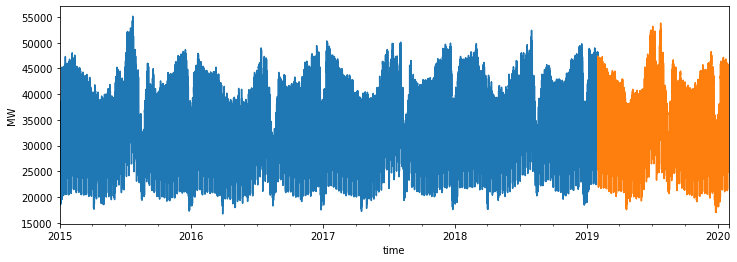

In [27]:
ax = df_train["load"].plot(figsize=(12, 4), color="tab:blue")
_ = df_test["load"].plot(ax=ax, color="tab:orange", ylabel="MW")

## Data Preparation

There are no missing observations in our training data (there actually were a few missing observations on 15-min granularity, but we took care of these with hourly aggregation when loading the data).


Create features for training

The following features are used for training our forecast models :

    time features: month, weekday and hour
    national holiday features, as a boolean time series
    lag features: load data with a lag values ranging from 24 to 48 hours



The lag features introduce a few missing values which we will move out of the analysis. The features of our training set are then the following :

In [28]:
df_train.loc[df_train["load"].isna(), :].index
df_train = add_all_features(df_train).dropna()
df_test = add_all_features(df_test).dropna()
df_train.info()

target_col = "load"
X_train = df_train.drop(columns=target_col)
y_train = df_train.loc[:, target_col]
X_test = df_test.drop(columns=target_col)
y_test = df_test.loc[:, target_col]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35760 entries, 2015-01-03 00:00:00+00:00 to 2019-01-31 23:00:00+00:00
Freq: H
Data columns (total 30 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   load         35760 non-null  float64
 1   month        35760 non-null  int64  
 2   weekday      35760 non-null  int64  
 3   hour         35760 non-null  int64  
 4   holiday      35760 non-null  int64  
 5   load_lag_24  35760 non-null  float64
 6   load_lag_25  35760 non-null  float64
 7   load_lag_26  35760 non-null  float64
 8   load_lag_27  35760 non-null  float64
 9   load_lag_28  35760 non-null  float64
 10  load_lag_29  35760 non-null  float64
 11  load_lag_30  35760 non-null  float64
 12  load_lag_31  35760 non-null  float64
 13  load_lag_32  35760 non-null  float64
 14  load_lag_33  35760 non-null  float64
 15  load_lag_34  35760 non-null  float64
 16  load_lag_35  35760 non-null  float64
 17  load_lag_36  35760 non-null  floa

We then separate target values from features into distinct data frames.

We'll use the following data preparation pipeline to apply one-hot encoders on categorical feratures (time features), and a standard scaler on numerical features (lag features).

We then fit pipeline on training data, and apply it on training and test sets

In [29]:
feature_names, prep_pipeline = fit_prep_pipeline(X_train)

X_train_prep = prep_pipeline.transform(X_train)
X_train_prep = pd.DataFrame(X_train_prep, columns=feature_names, index=df_train.index)
X_test_prep = prep_pipeline.transform(X_test)
X_test_prep = pd.DataFrame(X_test_prep, columns=feature_names, index=df_test.index)

X_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35760 entries, 2015-01-03 00:00:00+00:00 to 2019-01-31 23:00:00+00:00
Freq: H
Data columns (total 69 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   month_1      35760 non-null  float64
 1   month_2      35760 non-null  float64
 2   month_3      35760 non-null  float64
 3   month_4      35760 non-null  float64
 4   month_5      35760 non-null  float64
 5   month_6      35760 non-null  float64
 6   month_7      35760 non-null  float64
 7   month_8      35760 non-null  float64
 8   month_9      35760 non-null  float64
 9   month_10     35760 non-null  float64
 10  month_11     35760 non-null  float64
 11  month_12     35760 non-null  float64
 12  weekday_0    35760 non-null  float64
 13  weekday_1    35760 non-null  float64
 14  weekday_2    35760 non-null  float64
 15  weekday_3    35760 non-null  float64
 16  weekday_4    35760 non-null  float64
 17  weekday_5    35760 non-null  floa

## Training regression models

A model be trained for our prediction task : Gradient boosting model (based on XGBoost library).

In [30]:
xgb_model = XGBRegressor(objective ='reg:squarederror', n_estimators=1000)

### Learning curves 

The behaviour and performance of the previous models can be represented with learning curves. These are showing the models performance evolution based on experience (the amount of training data that is fed to the algorithm).

The linear model achieves a validation RMSE of ±3230MW. The training RMSE is ±3100MW which is relatively close.

In [ ]:
xgb_steps, xgb_train_mse, xgb_val_mse = compute_learning_curves(
    xgb_model, X_train_prep, y_train, 1000, verbose=True
)

Iteration 1/29: train_rmse=136.23, val_rmse=2719.66
Iteration 2/29: train_rmse=295.12, val_rmse=2439.68
Iteration 3/29: train_rmse=438.50, val_rmse=2286.66
Iteration 4/29: train_rmse=521.49, val_rmse=2130.67
Iteration 5/29: train_rmse=590.48, val_rmse=1947.60
Iteration 6/29: train_rmse=671.26, val_rmse=1806.49
Iteration 7/29: train_rmse=670.86, val_rmse=1822.81
Iteration 8/29: train_rmse=691.40, val_rmse=1823.26
Iteration 9/29: train_rmse=838.61, val_rmse=1854.16
Iteration 10/29: train_rmse=851.12, val_rmse=1818.19
Iteration 11/29: train_rmse=864.04, val_rmse=1795.28
Iteration 12/29: train_rmse=931.23, val_rmse=1820.87
Iteration 13/29: train_rmse=991.19, val_rmse=1821.06
Iteration 14/29: train_rmse=1020.59, val_rmse=1770.23
Iteration 15/29: train_rmse=1068.17, val_rmse=1768.84


In [ ]:
xgb_model.fit(X_train_prep, y=y_train)

Skip the Hyperparameters tuning here

In [ ]:
pred_df = compute_predictions_df(
    xgb_model, X_test_prep, y_test
)
pred_df.head()

In [ ]:
plot_predictions(pred_df)